# Registration test


In [217]:
import cv2 as cv
import imutils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

import functools
imgshowg = functools.partial(plt.imshow, cmap='gray', interpolation='none', vmin=0, vmax=255)
imgshowc = functools.partial(plt.imshow, interpolation='none', vmin=0, vmax=255)

matplotlib.rc('figure', figsize=(14, 10))

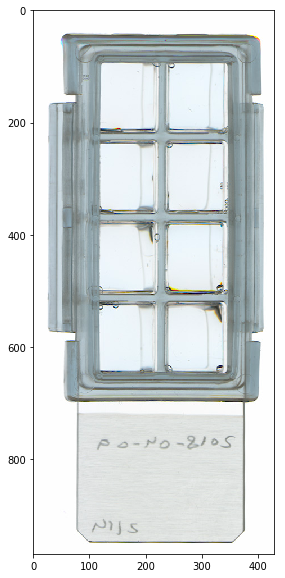

In [218]:
ref = cv.imread('./CellRef.jpg')
plt.imshow(ref)
plt.show()

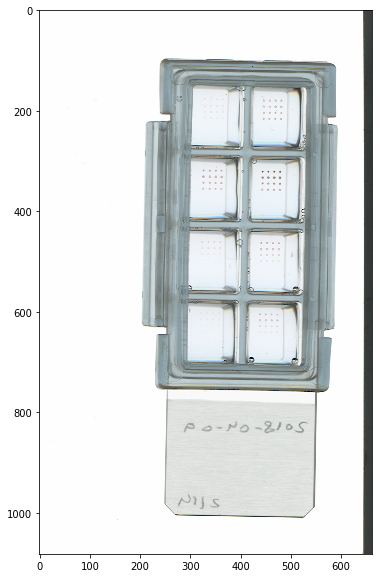

In [219]:
target = cv.imread("../test_img/04_end.tif")
plt.imshow(target)
plt.show()

In [220]:
# FROM: https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.10
 
def alignImages(im1, im2, max_features=MAX_FEATURES, good_match_percent=GOOD_MATCH_PERCENT):
  # Convert images to grayscale
  im1Gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
  im2Gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)
   
  # Detect ORB features and compute descriptors.
  orb = cv.ORB_create(max_features)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
   
  # Match features.
  matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
   
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * good_match_percent)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  imMatches = cv.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
   
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
   
  # Find homography
  h, mask = cv.findHomography(points1, points2, cv.RANSAC)
 
  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv.warpPerspective(im1, h, (width, height))
   
  return im1Reg, imMatches


In [221]:
# Is this stable/deterministic
for repetition in range(3):
    for max_feats in [100, 200, 300, 400, 500]:
        for good_matches in [0.05, 0.10, 0.15]:#, 0.20, 0.25]:        
            # TODO: error handling for non-matching images
            try:
                imReg, imMatches = alignImages(target, ref, max_feats, good_matches)
            except Exception as e:
                print(e)

            # Write aligned image to disk. 
            outFilename = f'aligned_{max_feats}_{good_matches}_{repetition}.jpg'
            cv.imwrite(outFilename, imReg)

            outFilename = f'matches_{max_feats}_{good_matches}_{repetition}.jpg'
            cv.imwrite(outFilename, imMatches)



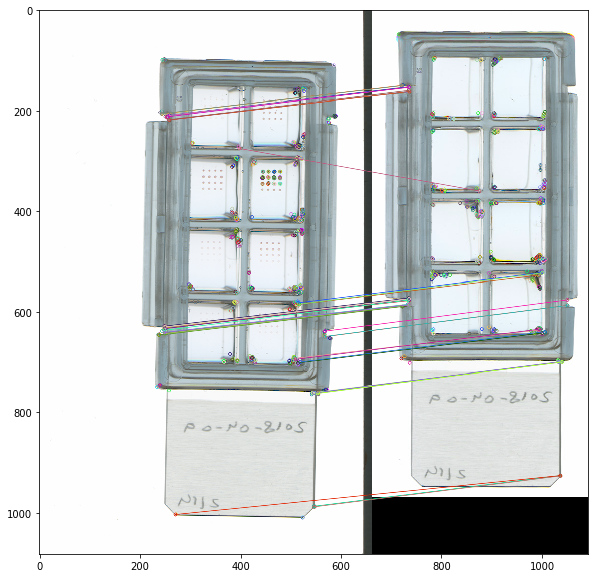

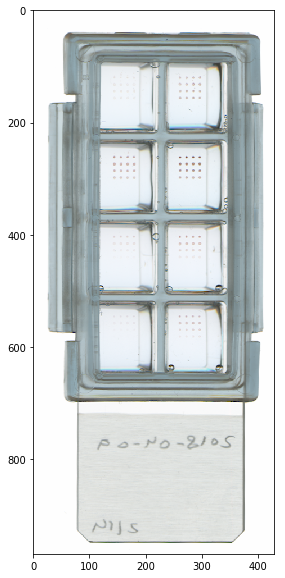

In [222]:
# Chose configuration
max_feats = 500
good_matches = 0.1
try:
    aligned, matches = alignImages(target, ref, max_feats, good_matches)
    
except Exception as e:
    print(e)

plt.imshow(matches)
plt.show()

plt.imshow(aligned)
plt.show()



In [223]:
# Extracted grid origin by hand
grid_positions = [
  [138, 114],
  [255, 114],
  [138, 256],
  [255, 256],
  [138, 398],
  [255, 398],
  [138, 540],
  [255, 540]
]

def get_grid_elements(roi, ncols=4, nrows=4):
    rows = np.split(roi, nrows, axis=0)
    cells = [np.split(row, ncols, axis=1) for row in rows]
    return np.stack(cells)

def extract_all_grids(image, grid_pos, grid_size=48):
    grids = []
    for x, y in grid_pos:
        grids.append(get_grid_elements(image[y:y+grid_size, x:x+grid_size]))
    return np.stack(grids)

In [224]:
# Load a aligned template with annoted cells in order to test point extraction
#aligned_text = cv.imread('./aligned_text.tif')
# aligned_text = cv.cvtColor(aligned_text, cv.COLOR_BGR2GRAY)

In [225]:
# Extract grids
aligned_gray = cv.cvtColor(aligned, cv.COLOR_BGR2GRAY)
grids = extract_all_grids(aligned_gray, grid_positions)

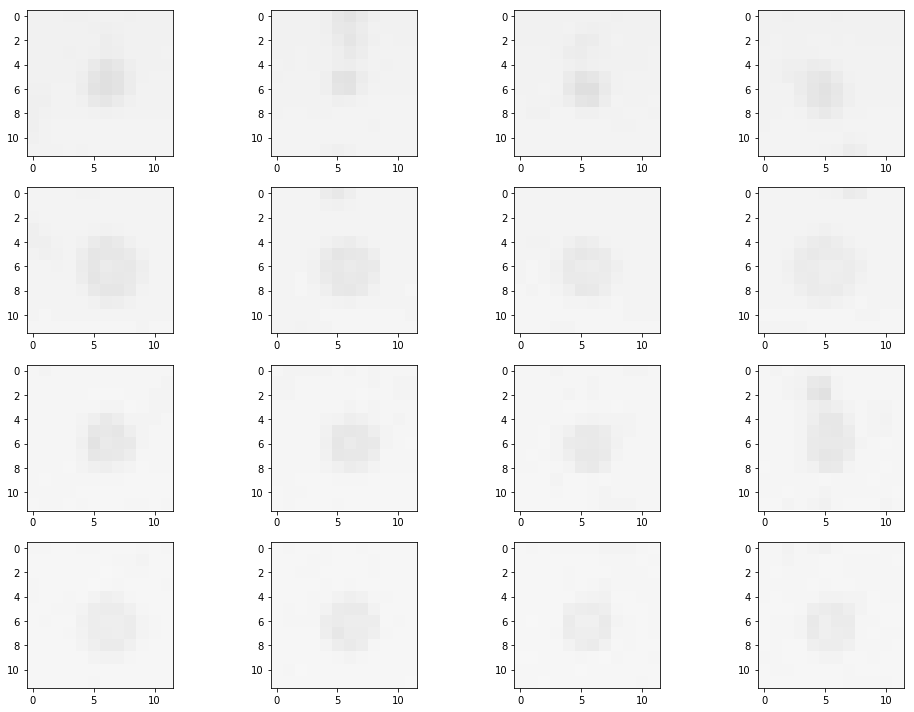

In [226]:
# Plot all points of a cell
cell = 0
plt.subplots(4, 4)
for row in range(4):
    for column in range(4):
        plt.subplot(4, 4, row*4 + column + 1)
        imgshowg(grids[cell, row, column, :, :])
    
plt.tight_layout()
plt.show()

In [227]:
# Quantify the point content for all cells

def quantify_point(image):
    #return np.mean(image)
    return np.sum(image)

# Iterate over the grid assuming structure [grid pos, cell row, cell column, cell data]
quantgrids = np.zeros(shape=grids.shape[0:-2] + (1,))
shape = grids.shape
for grid_pos in range(shape[0]):
    for row in range(shape[1]):
        for column in range(shape[2]):
            quantgrids[grid_pos, row, column] = quantify_point(grids[grid_pos, row, column, :, :])

In [228]:
print(f'min: {quantgrids.min()}, max: {quantgrids.max()}')


min: 32572.0, max: 35251.0


In [229]:
# Transform the numpy array into a pandas.DataFrame and write it to csv
shape = quantgrids.shape
cells = np.repeat(range(shape[0]), shape[1]*shape[2])
rows = np.tile(np.repeat(range(shape[1]), shape[2]), shape[0])
columns = np.tile(np.tile(range(shape[2]), shape[1]), shape[0])
quant_table = pd.DataFrame({'cell': cells, 'row': rows, 'column': columns, 'point':quantgrids.ravel()})

In [230]:
quant_table

,cell,row,column,point
0,0,0,0,34588.0
1,0,0,1,34647.0
2,0,0,2,34675.0
3,0,0,3,34655.0
4,0,1,0,34763.0
5,0,1,1,34837.0
6,0,1,2,34954.0
7,0,1,3,34876.0
8,0,2,0,35085.0
9,0,2,1,35090.0


In [231]:
print(quantgrids[7, 1, :])

print(quantgrids[7, 2, :])

[[34140.]
 [34146.]
 [34148.]
 [34144.]]
[[34684.]
 [34740.]
 [34727.]
 [34645.]]


In [232]:
quant_table.to_csv('test_results.csv', index=False)

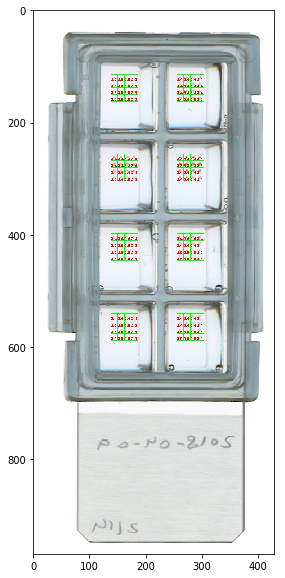

In [233]:
def label_intensities(img, grid_positions, values, grid_size=48, nrows=4, ncols=4, strformat='%.1f'):
    labeled = img.copy()
    for grid_pos,(x,y) in enumerate(grid_positions):
        cv.rectangle(labeled, (x, y), (x + grid_size, y + grid_size), (0, 255, 0), 1)
        for row in range(1, nrows):
            cv.line(labeled, (x, y + grid_size//nrows * row), (x + grid_size, y + grid_size//nrows * row), (0, 255, 0), 1)
        for col in range(1, ncols):
            cv.line(labeled, (x + grid_size//nrows * col, y), (x + grid_size//nrows * col, y + grid_size), (0, 255, 0), 1)
        for row in range(nrows):
            for col in range(ncols):
                tX = x + grid_size//nrows * col 
                tY = y + grid_size//nrows * (row + 1) - 1
                value = strformat % (values[grid_pos, row, col])

                cv.putText(labeled, value, (tX, tY), cv.FONT_HERSHEY_SIMPLEX, 0.2, (255, 0, 0))
                
    return labeled

# TODO: divided by 10000 to make text fit somehow in this low res image
labeled = label_intensities(aligned, grid_positions, quantgrids / 10000)
cv.imwrite("labeled.png", labeled)
imgshowc(labeled)